In [ ]:
!pip install miseval
import miseval

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

import cv2 as cv

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

from skimage.filters import threshold_multiotsu

import copy

from random import random

from pprint import pprint

In [ ]:
from google.colab import drive 

drive.mount("./drive")

Mounted at ./drive


In [ ]:
!cp /content/drive/MyDrive/Data4ProjInitiation.zip .
!unzip Data4ProjInitiation.zip

In [ ]:
imagesPath = "/content/content/Data4ProjInitiation/images/"
labelsPath = "/content/content/Data4ProjInitiation/labels/"

Images = []
Labels = []

for _,_,FileNames in os.walk(imagesPath):
  for i in FileNames:
    Images.append(imagesPath+i)


for _,_,FileNames in os.walk(labelsPath):
  for i in FileNames:
    Labels.append(labelsPath+i)


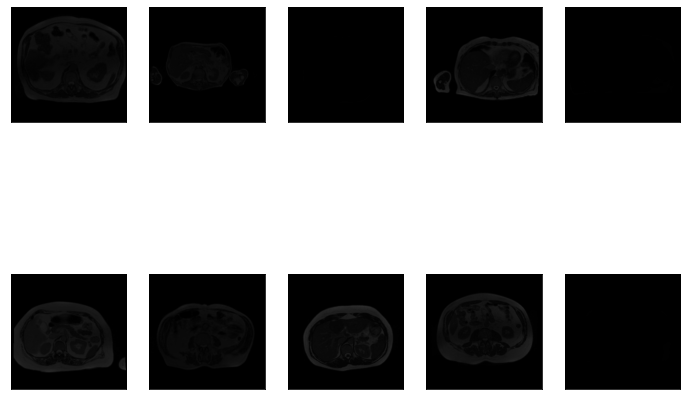

In [ ]:
plt.figure(figsize=(12,9))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(cv.imread(Images[i]))

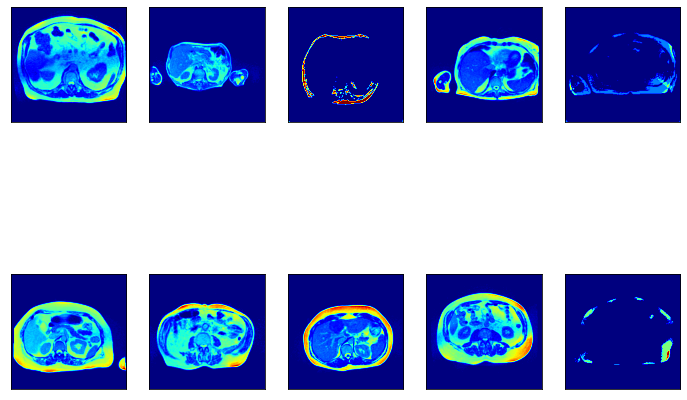

In [ ]:
from random import random
plt.figure(figsize=(12,9))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(cv.cvtColor(cv.imread(Images[i]),cv.COLOR_RGB2GRAY),cmap="jet")

**Segmentation using thresholding**

In [ ]:
def segmentThresholding(image, nbSegments):
    gImage = cv.cvtColor(image,cv.COLOR_RGB2GRAY)
    
    try:
      threshs = threshold_multiotsu(gImage,classes=nbSegments)
    except:
      nb = len(np.unique(gImage))
      threshs = threshold_multiotsu(gImage,classes=nb)
    
    cpt = 0    
    step = 255//nbSegments    
    for i in range(len(threshs)):        
        if i == 0:
            gImage[gImage<threshs[i]]= cpt            
        else:
            gImage[(gImage>threshs[i-1]) & (gImage<threshs[i])]= cpt           
        cpt+=1

    # if the background was annotated with a pixel different than 0 then swap
    background = gImage[0][0]
    if(background!=0):
      gImage[gImage==0] = 255
      gImage[gImage==background] = 0
      gImage[gImage==255] = background
    else:
      pass

    
    gImage[(gImage!=0) & (gImage!=1) & (gImage!=2) & (gImage!=3)] = 4            

  
    # permitations 
    # 1 <==> 2
    try:
      gImage2 = copy.deepcopy(gImage)
      gImage2[gImage2==2] = 255
      gImage2[gImage2==1] = 2
      gImage2[gImage2==255] = 1          
    except:
      gImage2 = None
    # 1 <==> 3
    try:
      gImage3 = copy.deepcopy(gImage)
      gImage3[gImage3==3] = 255
      gImage3[gImage3==1] = 3
      gImage3[gImage3==255] = 1          
    except:
      gImage3 = None
    # 2 <==> 3
    try:
      gImage4 = copy.deepcopy(gImage)
      gImage4[gImage4==3] = 255
      gImage4[gImage4==2] = 3
      gImage4[gImage4==255] = 2
    except: 
      gImage4 = None

    #regions = np.digitize(gImage, bins=threshs)
    return (gImage,gImage2,gImage3,gImage4)

**segmentaion using Kmeans**

In [ ]:
def segmentKmeans(image, nbSegments):
    gImage = cv.cvtColor(image,cv.COLOR_RGB2GRAY)
    
    try:
      kmeans = KMeans(n_clusters=nbSegments, random_state=0).fit(gImage.reshape((gImage.shape[0]*gImage.shape[1],1)))
    except:
      nb = len(np.unique(gImage))
      kmeans = KMeans(n_clusters=nb, random_state=0).fit(gImage.reshape((gImage.shape[0]*gImage.shape[1],1)))
    
    mask = kmeans.predict(gImage.reshape((gImage.shape[0]*gImage.shape[1],1))).reshape(gImage.shape[0],gImage.shape[1])
    
    # for each class(segment) give the same intensity value:
    cpt = 0
    step = 255//nbSegments

    for i in range(nbSegments):        
        mask[mask==i] = cpt
        cpt+=1
    
    background = mask[0][0]
    if(background!=0):
      mask[mask==0] = 255
      mask[mask==background] = 0
      mask[mask==255] = background
    else:
      pass
      
    mask[(mask!=0) & (mask!=1) & (mask!=2) & (mask!=3)] = 4            
    
    # permitations 
    # 1 <==> 2
    try:
      gImage2 = copy.deepcopy(mask)
      gImage2[gImage2==2] = 255
      gImage2[gImage2==1] = 2
      gImage2[gImage2==255] = 1          
    except:
      gImage2 = None
    # 1 <==> 3
    try:
      gImage3 = copy.deepcopy(mask)
      gImage3[gImage3==3] = 255
      gImage3[gImage3==1] = 3
      gImage3[gImage3==255] = 1          
    except:
      gImage3 = None
    # 2 <==> 3
    try:
      gImage4 = copy.deepcopy(mask)
      gImage4[gImage4==3] = 255
      gImage4[gImage4==2] = 3
      gImage4[gImage4==255] = 2
    except: 
      gImage4 = None


    return (mask,gImage2,gImage3,gImage4)

**Tests**

**Kmeans**

In [ ]:
IoUs = []
Dices = []
ACCs = []
PRECs = []

indexs = []

for i in range(1000):
  
  ok = False
  while(not ok):
    ind = int(random()*3000)
    if(ind in indexs):
      ok = False
    else:
      ok = True
  indexs.append(ind)
  
  predictedKmeans = segmentKmeans(cv.imread(Images[ind]),5)
  tmp1 = []
  tmp2 = []
  tmp3 = []
  tmp4 = []
  for p in predictedKmeans:  
    if(len(p)>0):
      tmp1.append(np.mean(miseval.evaluate(cv.imread(Labels[ind])[:,:,1],p,metric="IoU",multi_class=True, n_classes=5)))
      tmp2.append(np.mean(miseval.evaluate(cv.imread(Labels[ind])[:,:,1],p,metric="DSC",multi_class=True, n_classes=5)))
      tmp3.append(np.mean(miseval.evaluate(cv.imread(Labels[ind])[:,:,1],p,metric="ACC",multi_class=True, n_classes=5)))
      tmp4.append(np.mean(miseval.evaluate(cv.imread(Labels[ind])[:,:,1],p,metric="PREC",multi_class=True, n_classes=5)))
  
  IoUs.append(np.max(tmp1))
  Dices.append(np.max(tmp2))
  ACCs.append(np.max(tmp3))
  PRECs.append(np.max(tmp4))

meanIoUForKmeans = np.mean(IoUs)
meanDiceForKmeans = np.mean(Dices)
meanACCForKmeans = np.mean(ACCs)
meanPRECForKmeans = np.mean(PRECs)

meanIoUForKmeans, meanDiceForKmeans, meanACCForKmeans, meanPRECForKmeans


In [ ]:
IoUExamples = []
DICEExamples = []
ACCExamples = []
PRECExamples = []

indexs = []

for i in range(10):
  ok = False
  while(not ok):
    ind = int(random()*3000)
    if(ind in indexs):
      ok = False
    else:
      ok = True
  indexs.append(ind)
  predictedKmeans = segmentKmeans(cv.imread(Images[ind]),5)
  maxIou = 0
  iou = []

  maxDICE = 0
  dice = []

  maxACC = 0
  acc = []

  maxPREC = 0
  prec = []
  for p in predictedKmeans:   
    tmpiou = miseval.evaluate(cv.imread(Labels[ind])[:,:,1],p,metric="IoU",multi_class=True, n_classes=5) 
    tmpdice = miseval.evaluate(cv.imread(Labels[ind])[:,:,1],p,metric="DSC",multi_class=True, n_classes=5) 
    tmpacc = miseval.evaluate(cv.imread(Labels[ind])[:,:,1],p,metric="ACC",multi_class=True, n_classes=5) 
    tmpprec = miseval.evaluate(cv.imread(Labels[ind])[:,:,1],p,metric="PREC",multi_class=True, n_classes=5) 

    if(maxIou < np.mean(tmpiou)):
      maxIou = np.mean(tmpiou)
      iou = tmpiou
    
    if(maxDICE < np.mean(tmpdice)):
      maxDICE = np.mean(tmpdice)
      dice = tmpdice
    
    if(maxACC < np.mean(tmpacc)):
      maxACC = np.mean(tmpacc)
      acc = tmpacc
    
    
    if(maxPREC < np.mean(tmpprec)):
      maxPREC = np.mean(tmpprec)
      prec = tmpprec
  
  IoUExamples.append((iou,ind))
  DICEExamples.append((dice,ind))
  ACCExamples.append((acc,ind))
  PRECExamples.append((prec,ind))


<ipython-input-60-55c24b07648b>:5: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=nbSegments, random_state=0).fit(gImage.reshape((gImage.shape[0]*gImage.shape[1],1)))
<ipython-input-60-55c24b07648b>:5: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=nbSegments, random_state=0).fit(gImage.reshape((gImage.shape[0]*gImage.shape[1],1)))
<ipython-input-60-55c24b07648b>:5: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=nbSegments, random_state=0).fit(gImage.reshape((gImage.shape[0]*gImage.shape[1],1)))
<ipython-input-60-55c24b07648b>:5: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  kmeans = KMe

In [ ]:
  pprint(IoUExamples)
  print("-------------------------------")
  pprint(DICEExamples)
  print("-------------------------------")
  pprint(ACCExamples)
  print("-------------------------------")
  pprint(PRECExamples)

[(array([0.84979539, 0.13233337, 0.00272686, 0.0308922 , 0.09524175]), 2816),
 (array([0.98096778, 0.78571429, 0.00680272, 0.        , 0.        ]), 2266),
 (array([0.87662482, 0.        , 0.03257329, 0.07947607, 0.15983279]), 871),
 (array([0.99311787, 0.65395349, 0.        , 0.        , 0.        ]), 119),
 (array([0.94854164, 0.92219917, 0.02777778, 0.        , 0.        ]), 2237),
 (array([0.93629863, 0.04082679, 0.00193648, 0.0546661 , 0.26829001]), 1213),
 (array([0.95888203, 0.85680059, 0.69878957, 0.0681431 , 0.        ]), 2186),
 (array([0.97258792, 0.12726211, 0.        , 0.        , 0.        ]), 2470),
 (array([0.96202199, 0.98440546, 0.        , 0.        , 0.        ]), 1654),
 (array([0.93170009, 0.95974705, 0.13696613, 0.        , 0.        ]), 2420)]
-------------------------------
[(array([0.91879934, 0.23373571, 0.00543889, 0.05993294, 0.17391914]), 2816),
 (array([0.99039246, 0.88      , 0.01351351, 0.        , 1.        ]), 2266),
 (array([0.93425687, 0.        , 0

<ipython-input-60-55c24b07648b>:5: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=nbSegments, random_state=0).fit(gImage.reshape((gImage.shape[0]*gImage.shape[1],1)))
<ipython-input-60-55c24b07648b>:5: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=nbSegments, random_state=0).fit(gImage.reshape((gImage.shape[0]*gImage.shape[1],1)))
<ipython-input-60-55c24b07648b>:5: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=nbSegments, random_state=0).fit(gImage.reshape((gImage.shape[0]*gImage.shape[1],1)))
<ipython-input-60-55c24b07648b>:5: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  kmeans = KMe

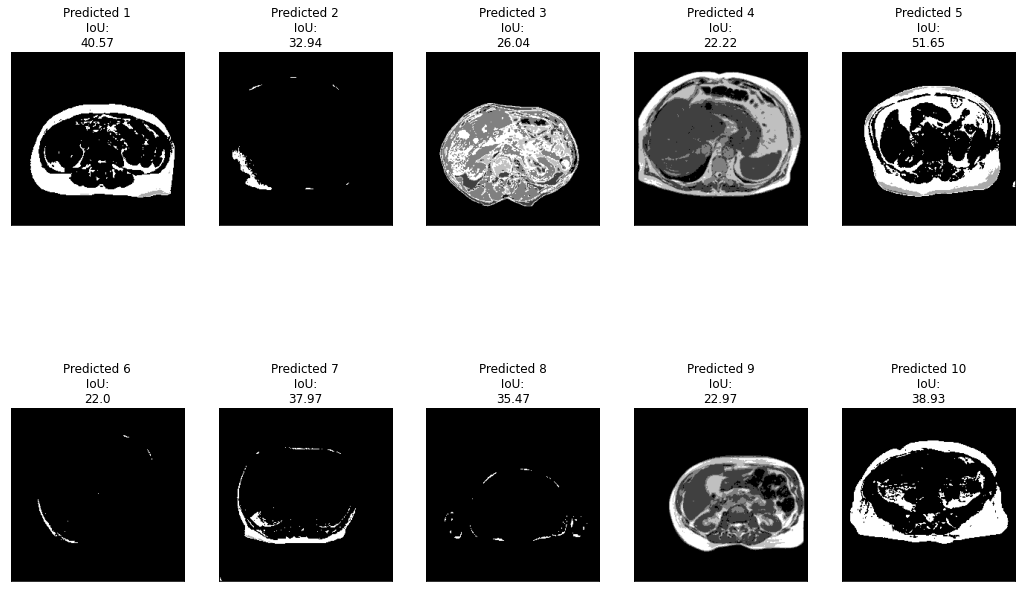

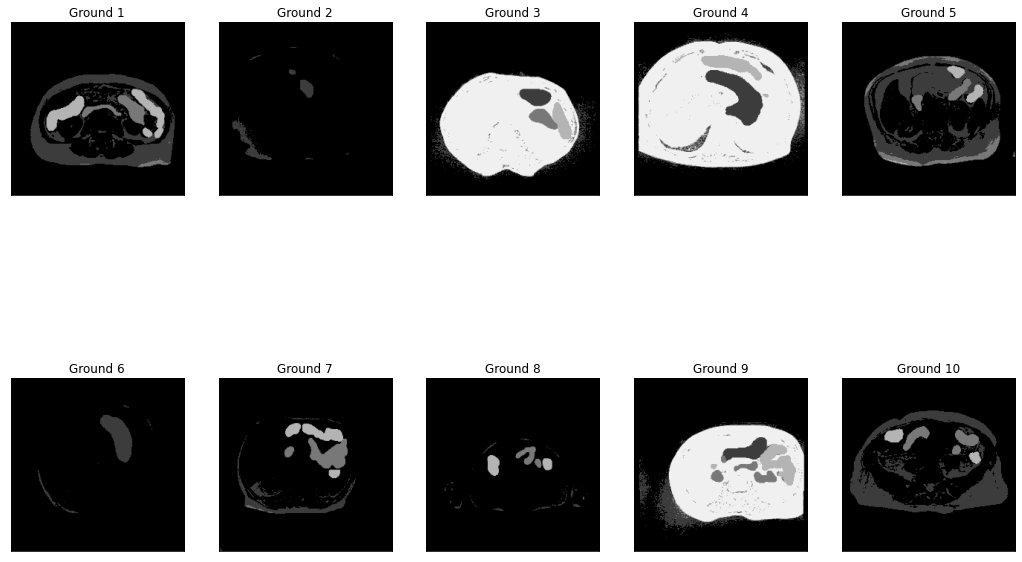

In [ ]:
# show some samples (10) 

plt.figure(figsize=(18,12))
indxs = []
for i in range(10):
  ok = False
  while(not ok):
    ind = int(random()*len(IoUExamples))
    indx = IoUExamples[ind][1]
    if(indx in indxs):
      ok = False
    else:
      ok = True
  indxs.append(indx)
  predictedKmeans = segmentKmeans(cv.imread(Images[indx]),5)


  plt.subplot(2,5,i+1)
  plt.imshow(predictedKmeans[2]*60,cmap="gray")
  plt.xticks([])
  plt.yticks([])
  plt.title("Predicted "+ str(i+1) + "\n IoU: \n"+ str(np.around(np.mean(IoUExamples[ind][0])*100,2)))


plt.figure(figsize=(18,12))
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(cv.imread(Labels[indxs[i]])*60,cmap="gray")
  plt.xticks([])
  plt.yticks([])
  plt.title("Ground "+ str(i+1))




**Thresholding**

In [ ]:
IoUs = []
Dices = []
ACCs = []
PRECs = []

indexs = []

for i in range(1000):
  ok = False
  while(not ok):
    ind = int(random()*3000)
    if(ind in indexs):
      ok = False
    else:
      ok = True
  indexs.append(ind)
  predictedThresh = segmentThresholding(cv.imread(Images[ind]),5)
  tmp1 = []
  tmp2 = []
  tmp3 = []
  tmp4 = []
  for p in predictedThresh:  
    if(len(p)>0):
      tmp1.append(np.mean(miseval.evaluate(cv.imread(Labels[ind])[:,:,1],p,metric="IoU",multi_class=True, n_classes=5)))
      tmp2.append(np.mean(miseval.evaluate(cv.imread(Labels[ind])[:,:,1],p,metric="DSC",multi_class=True, n_classes=5)))
      tmp3.append(np.mean(miseval.evaluate(cv.imread(Labels[ind])[:,:,1],p,metric="ACC",multi_class=True, n_classes=5)))
      tmp4.append(np.mean(miseval.evaluate(cv.imread(Labels[ind])[:,:,1],p,metric="PREC",multi_class=True, n_classes=5)))
  
  IoUs.append(np.max(tmp1))
  Dices.append(np.max(tmp2))
  ACCs.append(np.max(tmp3))
  PRECs.append(np.max(tmp4))

meanIoUForKmeans = np.mean(IoUs)
meanDiceForKmeans = np.mean(Dices)
meanACCForKmeans = np.mean(ACCs)
meanPRECForKmeans = np.mean(PRECs)

meanIoUForKmeans, meanDiceForKmeans, meanACCForKmeans, meanPRECForKmeans


(0.3447477479359601,
 0.4808671840815012,
 0.9049891664840382,
 0.49556575393107855)

In [ ]:
IoUExamples = []
DICEExamples = []
ACCExamples = []
PRECExamples = []

indexs = []

for i in range(10):
  ok = False
  while(not ok):
    ind = int(random()*3000)
    if(ind in indexs):
      ok = False
    else:
      ok = True
  indexs.append(ind)
  predictedThresh = segmentThresholding(cv.imread(Images[ind]),5)
  maxIou = 0
  iou = []

  maxDICE = 0
  dice = []

  maxACC = 0
  acc = []

  maxPREC = 0
  prec = []
  for p in predictedThresh:   
    tmpiou = miseval.evaluate(cv.imread(Labels[ind])[:,:,1],p,metric="IoU",multi_class=True, n_classes=5) 
    tmpdice = miseval.evaluate(cv.imread(Labels[ind])[:,:,1],p,metric="DSC",multi_class=True, n_classes=5) 
    tmpacc = miseval.evaluate(cv.imread(Labels[ind])[:,:,1],p,metric="ACC",multi_class=True, n_classes=5) 
    tmpprec = miseval.evaluate(cv.imread(Labels[ind])[:,:,1],p,metric="PREC",multi_class=True, n_classes=5) 

    if(maxIou < np.mean(tmpiou)):
      maxIou = np.mean(tmpiou)
      iou = tmpiou
    
    if(maxDICE < np.mean(tmpdice)):
      maxDICE = np.mean(tmpdice)
      dice = tmpdice
    
    if(maxACC < np.mean(tmpacc)):
      maxACC = np.mean(tmpacc)
      acc = tmpacc
    
    
    if(maxPREC < np.mean(tmpprec)):
      maxPREC = np.mean(tmpprec)
      prec = tmpprec
  
  IoUExamples.append((iou,ind))
  DICEExamples.append((dice,ind))
  ACCExamples.append((acc,ind))
  PRECExamples.append((prec,ind))


In [ ]:
  pprint(IoUExamples)
  print("-------------------------------")
  pprint(DICEExamples)
  print("-------------------------------")
  pprint(ACCExamples)
  print("-------------------------------")
  pprint(PRECExamples)

[(array([0.7970617 , 0.        , 0.06498865, 0.11850542, 0.24841129]), 147),
 (array([0.99311787, 0.65395349, 0.        , 0.        , 0.        ]), 119),
 (array([0.95417092, 0.        , 0.1034749 , 0.0162299 , 0.33810609]), 2944),
 (array([0.96110233, 0.92538265, 0.        , 0.        , 0.        ]), 1002),
 (array([0.97497664, 0.83838519, 1.        , 1.        , 0.        ]), 2893),
 (array([9.27191617e-01, 3.23834197e-04, 9.39443951e-02, 1.05780846e-01,
       4.05282104e-01]),
  845),
 (array([9.42482026e-01, 1.69405387e-04, 9.56425406e-02, 1.10664263e-01,
       3.21940326e-01]),
  1082),
 (array([0.94908579, 0.34372734, 1.        , 0.        , 0.        ]), 2426),
 (array([0.93742428, 0.45648604, 0.        , 0.        , 0.        ]), 713),
 (array([0.90239415, 0.        , 0.15728795, 0.04109387, 0.29865406]), 1041)]
-------------------------------
[(array([0.88707216, 0.        , 0.12204572, 0.21189958, 0.39796386]), 147),
 (array([0.99654705, 0.79077615, 1.        , 1.        , 

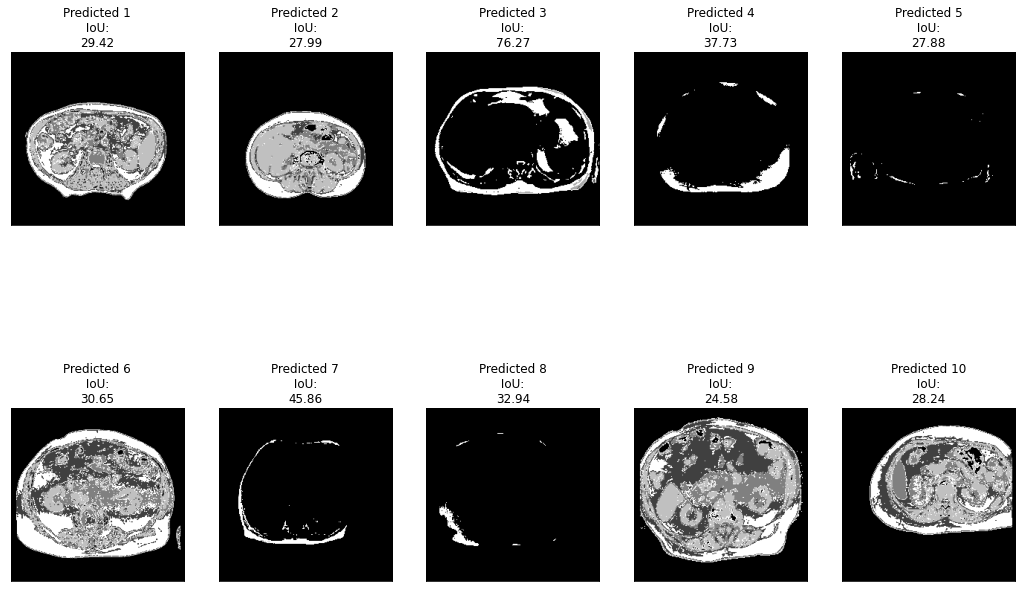

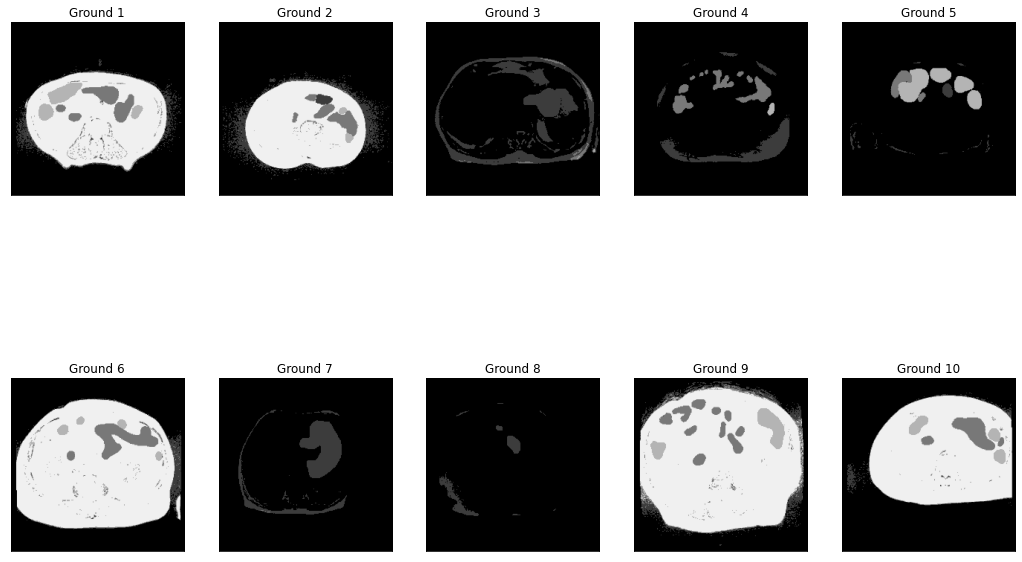

In [ ]:
# show some samples (10) 

plt.figure(figsize=(18,12))
indxs = []
for i in range(10):
  ok = False
  while(not ok):
    ind = int(random()*len(IoUExamples))
    indx = IoUExamples[ind][1]
    if(indx in indxs):
      ok = False
    else:
      ok = True
  indxs.append(indx)
  predictedThresh = segmentThresholding(cv.imread(Images[indx]),5)


  plt.subplot(2,5,i+1)
  plt.imshow(predictedThresh[2]*60,cmap="gray")
  plt.xticks([])
  plt.yticks([])
  plt.title("Predicted "+ str(i+1) + "\n IoU: \n"+ str(np.around(np.mean(IoUExamples[ind][0])*100,2)))


plt.figure(figsize=(18,12))
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(cv.imread(Labels[indxs[i]])*60,cmap="gray")
  plt.xticks([])
  plt.yticks([])
  plt.title("Ground "+ str(i+1))




**Segmenting each class alone : LargeBowel**

In [ ]:
!cp /content/drive/MyDrive/Data4ProjInitiationLargeBowel.zip .
!unzip Data4ProjInitiationLargeBowel.zip

In [ ]:
imagesPath = "/content/content/Data4ProjInitiationLargeBowel/images/"
labelsPath = "/content/content/Data4ProjInitiationLargeBowel/labels/"

Images = []
Labels = []

for _,_,FileNames in os.walk(imagesPath):
  for i in FileNames:
    Images.append(imagesPath+i)


for _,_,FileNames in os.walk(labelsPath):
  for i in FileNames:
    Labels.append(labelsPath+i)


In [ ]:
IoUs = []
Dices = []
ACCs = []
PRECs = []

indexs = []

for i in range(1000):
  
  ok = False
  while(not ok):
    ind = int(random()*3000)
    if(ind in indexs):
      ok = False
    else:
      ok = True
  indexs.append(ind)
  
  predictedKmeans = segmentKmeans(cv.imread(Images[ind]),2)
  tmp1 = []
  tmp2 = []
  tmp3 = []
  tmp4 = []
  for p in predictedKmeans:  
    if(len(p)>0):
      tmp1.append(np.mean(miseval.evaluate(cv.imread(Labels[ind])[:,:,1],p,metric="IoU",multi_class=True, n_classes=2)))
      tmp2.append(np.mean(miseval.evaluate(cv.imread(Labels[ind])[:,:,1],p,metric="DSC",multi_class=True, n_classes=2)))
      tmp3.append(np.mean(miseval.evaluate(cv.imread(Labels[ind])[:,:,1],p,metric="ACC",multi_class=True, n_classes=2)))
      tmp4.append(np.mean(miseval.evaluate(cv.imread(Labels[ind])[:,:,1],p,metric="PREC",multi_class=True, n_classes=2)))
  
  IoUs.append(np.max(tmp1))
  Dices.append(np.max(tmp2))
  ACCs.append(np.max(tmp3))
  PRECs.append(np.max(tmp4))

meanIoUForKmeans = np.mean(IoUs)
meanDiceForKmeans = np.mean(Dices)
meanACCForKmeans = np.mean(ACCs)
meanPRECForKmeans = np.mean(PRECs)

meanIoUForKmeans, meanDiceForKmeans, meanACCForKmeans, meanPRECForKmeans


(0.40342729253621745,
 0.4526074762904627,
 0.8871970834246476,
 0.49756919783886544)

In [ ]:
IoUExamples = []
DICEExamples = []
ACCExamples = []
PRECExamples = []

indexs = []

for i in range(10):
  ok = False
  while(not ok):
    ind = int(random()*3000)
    if(ind in indexs):
      ok = False
    else:
      ok = True
  indexs.append(ind)
  predictedKmeans = segmentKmeans(cv.imread(Images[ind]),2)
  maxIou = 0
  iou = []

  maxDICE = 0
  dice = []

  maxACC = 0
  acc = []

  maxPREC = 0
  prec = []
  for p in predictedKmeans:   
    tmpiou = miseval.evaluate(cv.imread(Labels[ind])[:,:,1],p,metric="IoU",multi_class=True, n_classes=2) 
    tmpdice = miseval.evaluate(cv.imread(Labels[ind])[:,:,1],p,metric="DSC",multi_class=True, n_classes=2) 
    tmpacc = miseval.evaluate(cv.imread(Labels[ind])[:,:,1],p,metric="ACC",multi_class=True, n_classes=2) 
    tmpprec = miseval.evaluate(cv.imread(Labels[ind])[:,:,1],p,metric="PREC",multi_class=True, n_classes=2) 

    if(maxIou < np.mean(tmpiou)):
      maxIou = np.mean(tmpiou)
      iou = tmpiou
    
    if(maxDICE < np.mean(tmpdice)):
      maxDICE = np.mean(tmpdice)
      dice = tmpdice
    
    if(maxACC < np.mean(tmpacc)):
      maxACC = np.mean(tmpacc)
      acc = tmpacc
    
    
    if(maxPREC < np.mean(tmpprec)):
      maxPREC = np.mean(tmpprec)
      prec = tmpprec
  
  IoUExamples.append((iou,ind))
  DICEExamples.append((dice,ind))
  ACCExamples.append((acc,ind))
  PRECExamples.append((prec,ind))


In [ ]:
  pprint(IoUExamples)
  print("-------------------------------")
  pprint(DICEExamples)
  print("-------------------------------")
  pprint(ACCExamples)
  print("-------------------------------")
  pprint(PRECExamples)

[(array([0.7329245, 0.0196792]), 2770),
 (array([0.73523145, 0.02145282]), 648),
 (array([0.77232512, 0.03046918]), 834),
 (array([0.6796875 , 0.00567956]), 2783),
 (array([0.83447995, 0.07099855]), 1370),
 (array([0.75337046, 0.01203405]), 1361),
 (array([0.73588473, 0.01882032]), 406),
 (array([0.80852154, 0.01115312]), 1870),
 (array([0.89949317, 0.018406  ]), 75),
 (array([0.74655394, 0.02447651]), 1604)]
-------------------------------
[(array([0.84588163, 0.03859881]), 2770),
 (array([0.847416  , 0.04200452]), 648),
 (array([0.87153888, 0.05913652]), 834),
 (array([0.80930233, 0.01129497]), 2783),
 (array([0.90977277, 0.13258383]), 1370),
 (array([0.85933974, 0.0237819 ]), 1361),
 (array([0.84784976, 0.03694532]), 406),
 (array([0.89412431, 0.0220602 ]), 1870),
 (array([0.94708755, 0.03614669]), 75),
 (array([0.85488793, 0.04778346]), 1604)]
-------------------------------
[(array([0.73434875, 0.99271313]), 2770),
 (array([0.73675944, 0.97658704]), 648),
 (array([0.77394258, 0.98

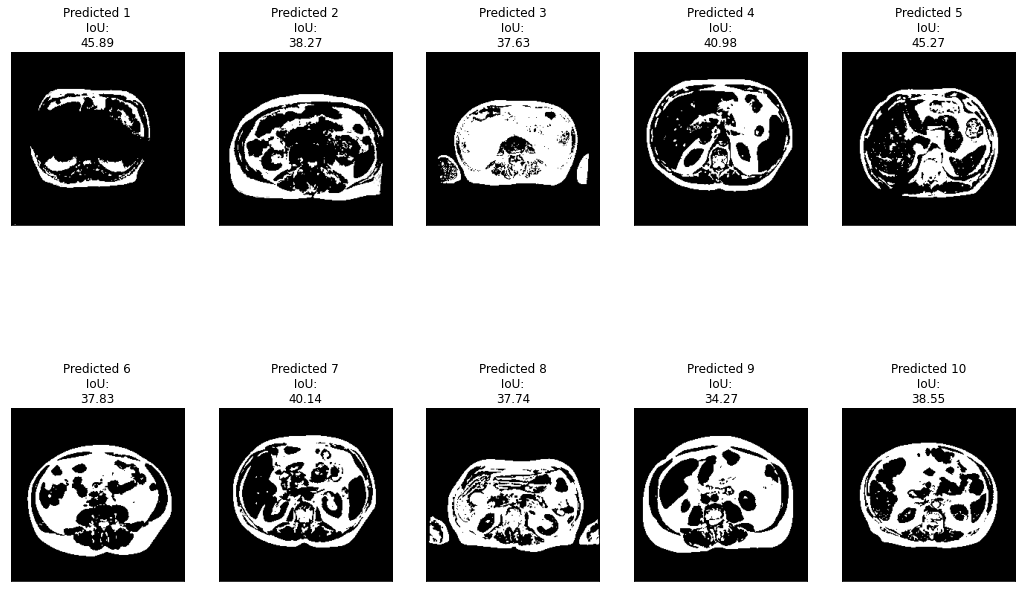

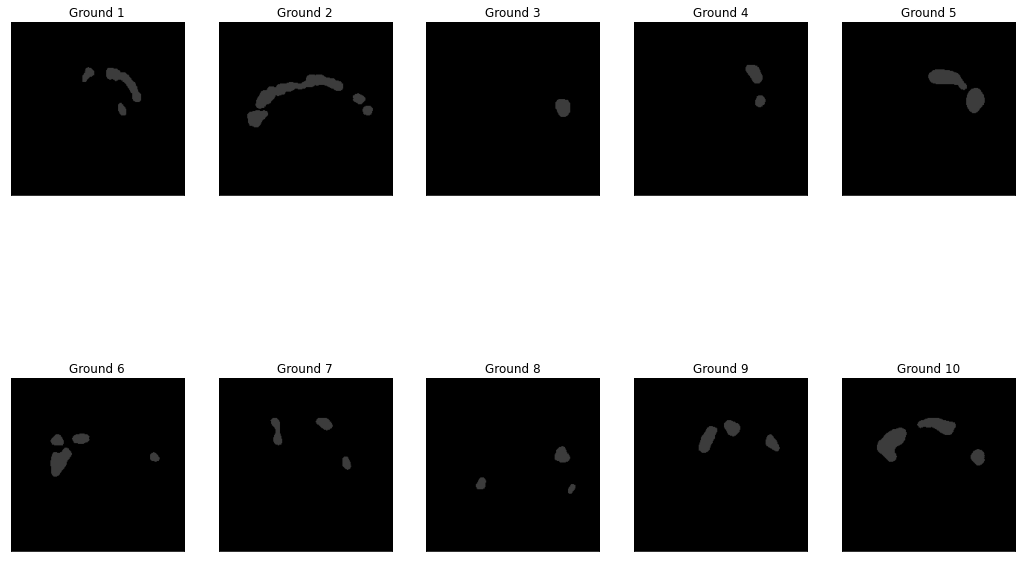

In [ ]:
# show some samples (10) 

plt.figure(figsize=(18,12))
indxs = []
for i in range(10):
  ok = False
  while(not ok):
    ind = int(random()*len(IoUExamples))
    indx = IoUExamples[ind][1]
    if(indx in indxs):
      ok = False
    else:
      ok = True
  indxs.append(indx)
  predictedThresh = segmentThresholding(cv.imread(Images[indx]),2)


  plt.subplot(2,5,i+1)
  plt.imshow(predictedThresh[2]*60,cmap="gray")
  plt.xticks([])
  plt.yticks([])
  plt.title("Predicted "+ str(i+1) + "\n IoU: \n"+ str(np.around(np.mean(IoUExamples[ind][0])*100,2)))


plt.figure(figsize=(18,12))
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(cv.imread(Labels[indxs[i]])*60,cmap="gray")
  plt.xticks([])
  plt.yticks([])
  plt.title("Ground "+ str(i+1))


